# Liveify Model Loading and Testing
Load a trained model and test it on audio samples.

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, '../')

from model import LiveifyModel
from dataset.dataset import StudioLiveDataModule

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

/home/vedpatel/.conda/envs/pyml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Load Model Checkpoint

In [ ]:
CHECKPOINT_PATH = "../../checkpoints/best.ckpt"
SAMPLE_RATE = 22050
SEGMENT_DURATION = 0.02  # 20ms segments

model = LiveifyModel(
    input_sr=int(SAMPLE_RATE * SEGMENT_DURATION),  # 441 samples
    output_sr=int(SAMPLE_RATE * SEGMENT_DURATION),
    hidden_channels=128,
    encoder_strides=[8, 4, 4],
    transformer_dim=(512 + 256) // 2,
    num_heads=8,
    num_layers=4,
    lr=3.5e-6,
).to(device)

print(f"Model created with input size: {int(SAMPLE_RATE * SEGMENT_DURATION)} samples")

if os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(state_dict)
    else:
        model.load_state_dict(checkpoint)
    
    print(f"✓ Loaded checkpoint from: {CHECKPOINT_PATH}")
else:
    print(f"⚠ Warning: Checkpoint not found at {CHECKPOINT_PATH}")
    print("  Using random initialization. Train the model first.")

model.eval()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")

Model created with input size: 110250 samples
✓ Loaded checkpoint from: ../../checkpoints/best.ckpt

Model parameters:
  Total: 8,652,033
  Trainable: 8,652,033


/mnt/Fedora2/code/Liveify/src/notebooks/../model.py:85: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


## Load Test Data

In [3]:
datamodule = StudioLiveDataModule(
    studio_dir="../../dataset/studio",
    live_dir="../../dataset/live",
    batch_size=4,
    sr=SAMPLE_RATE,
    segment_duration=SEGMENT_DURATION,
    num_workers=0,
    development_mode=True,
)

datamodule.setup()
val_loader = datamodule.val_dataloader()

print(f"✓ Loaded validation dataset")
print(f"  Batch size: 4")
print(f"  Sample rate: {SAMPLE_RATE} Hz")
print(f"  Segment duration: {SEGMENT_DURATION}s")

Loading Whisper model for lyric alignment...
Development mode: Loading only first pair...


Processing pairs: 100%|██████████| 1/1 [00:14<00:00, 14.64s/it, After Hours.mp3... → offset=-92.0s, sim=0.638, 44 segments of 5.0s]


Total segments: 44
Saving 44 segments to cache: ./cache/segments_c5b55e3cb7865f9d34f93e985d1f03fc.pkl
Cache saved successfully
Dataset split: 35 train, 9 val
✓ Loaded validation dataset
  Batch size: 4
  Sample rate: 22050 Hz
  Segment duration: 5.0s


## Run Inference on Test Batch

In [4]:
studio_audio, live_audio = next(iter(val_loader))
studio_audio = studio_audio.to(device)
live_audio = live_audio.to(device)

print(f"Input batch shapes:")
print(f"  Studio (input): {studio_audio.shape}")
print(f"  Live (target): {live_audio.shape}")

with torch.no_grad():
    output = model(studio_audio)

print(f"\nOutput shape: {output.shape}")

l1_loss = torch.nn.functional.l1_loss(output, live_audio).item()
mse_loss = torch.nn.functional.mse_loss(output, live_audio).item()

print(f"\nInference metrics:")
print(f"  L1 Loss: {l1_loss:.6f}")
print(f"  MSE Loss: {mse_loss:.6f}")

Input batch shapes:
  Studio (input): torch.Size([4, 110250])
  Live (target): torch.Size([4, 110250])

Output shape: torch.Size([4, 110250])

Inference metrics:
  L1 Loss: 0.151315
  MSE Loss: 0.050669


## Visualize Results

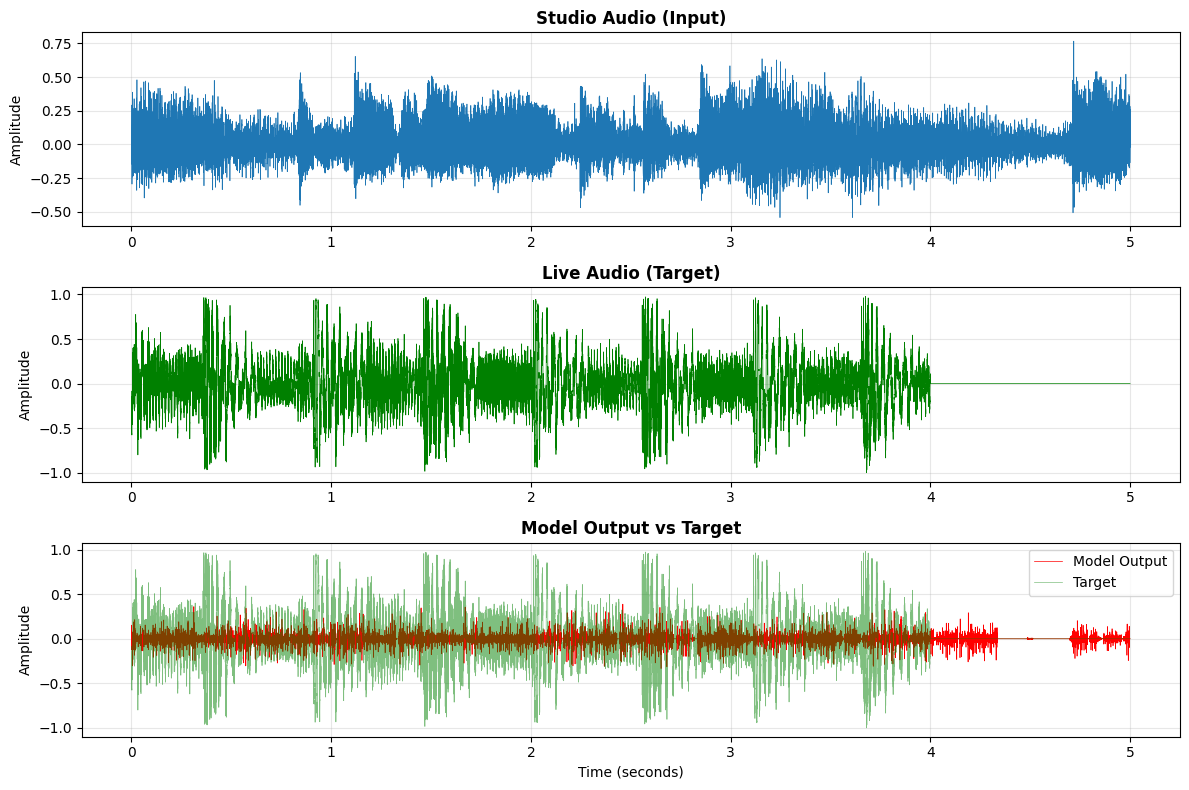

✓ Visualization saved to inference_results.png


In [5]:
sample_idx = 0
studio_np = studio_audio[sample_idx].cpu().numpy()
live_np = live_audio[sample_idx].cpu().numpy()
output_np = output[sample_idx].cpu().numpy()

fig, axes = plt.subplots(3, 1, figsize=(12, 8))
time_axis = np.arange(len(studio_np)) / SAMPLE_RATE

axes[0].plot(time_axis, studio_np, linewidth=0.5)
axes[0].set_title(f'Studio Audio (Input)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_axis, live_np, linewidth=0.5, color='green')
axes[1].set_title(f'Live Audio (Target)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

axes[2].plot(time_axis, output_np, linewidth=0.5, color='red', label='Model Output')
axes[2].plot(time_axis, live_np, linewidth=0.5, color='green', alpha=0.5, label='Target')
axes[2].set_title(f'Model Output vs Target', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Amplitude')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('inference_results.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to inference_results.png")

## Batch Processing Results

In [6]:
batch_size = studio_audio.shape[0]

print(f"Per-sample metrics (batch of {batch_size}):")
print(f"{'Sample':<8} {'L1 Loss':<12} {'MSE Loss':<12}")
print("-" * 32)

for i in range(batch_size):
    l1 = torch.nn.functional.l1_loss(output[i], live_audio[i]).item()
    mse = torch.nn.functional.mse_loss(output[i], live_audio[i]).item()
    print(f"{i:<8} {l1:<12.6f} {mse:<12.6f}")

print("-" * 32)
print(f"{'Mean':<8} {l1_loss:<12.6f} {mse_loss:<12.6f}")

Per-sample metrics (batch of 4):
Sample   L1 Loss      MSE Loss    
--------------------------------
0        0.162834     0.058110    
1        0.156397     0.050993    
2        0.147082     0.047439    
3        0.138945     0.046136    
--------------------------------
Mean     0.151315     0.050669    


## Test on Full Validation Set

In [7]:
all_l1_losses = []
all_mse_losses = []

with torch.no_grad():
    for batch_idx, (studio, live) in enumerate(val_loader):
        studio = studio.to(device)
        live = live.to(device)
        
        output = model(studio)
        
        l1 = torch.nn.functional.l1_loss(output, live).item()
        mse = torch.nn.functional.mse_loss(output, live).item()
        
        all_l1_losses.append(l1)
        all_mse_losses.append(mse)

mean_l1 = np.mean(all_l1_losses)
mean_mse = np.mean(all_mse_losses)
std_l1 = np.std(all_l1_losses)
std_mse = np.std(all_mse_losses)

print(f"Validation Set Results (all {len(all_l1_losses)} batches):")
print(f"  L1 Loss:  {mean_l1:.6f} ± {std_l1:.6f}")
print(f"  MSE Loss: {mean_mse:.6f} ± {std_mse:.6f}")

Validation Set Results (all 3 batches):
  L1 Loss:  0.119809 ± 0.041437
  MSE Loss: 0.036399 ± 0.019223
